In this notebook, we find the time complexity of the two algorithms: recursive and brute force.

In [1]:
import torch
import matplotlib.pyplot as plt
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
from spectre.spectrum_general import recursive_g
from spectre.spectrum_general import recursive_g_torch
from scipy.optimize import curve_fit
from spectre.model import HR
import numpy as np
import sympy as sp
import time

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"../figures/recursive_g/"

In [36]:
def system_matrices(n):
    # Y = torch.diag(torch.rand(n))
    A = torch.randn(n, n)
    Y = torch.mm(A, A.t())
    G = torch.randn(n, n)
    G = 0.9 * G / torch.max(torch.abs(torch.linalg.eigvals(G))) # redefining the spectral radius of G to be a 0.9
    return Y, G 

In [34]:
Y, G = system_matrices(5)

print(torch.linalg.eigvals(Y))

tensor([11.9577+0.j,  7.3076+0.j,  2.0409+0.j,  0.6306+0.j,  0.5383+0.j])


In [52]:
n_max = 30
input_sizes = np.unique(np.logspace(0, np.log10(n_max), 10, dtype=int))
print(input_sizes)

[ 1  2  3  4  6  9 14 20 29]


In [53]:
# find the recursive and brute force solutions
n_rep = 1
recursive_times = np.empty((len(input_sizes), n_rep), dtype=float)
brute_force_times = np.empty((len(input_sizes), n_rep), dtype=float)

for n in input_sizes:
    for rep in range(n_rep):
        Y, G = system_matrices(n)

        # recursive solution
        start_time = time.time()
        recursive_sol = recursive_g(G=G, Y=Y)
        # save the time to recursive_times at rep
        recursive_times[np.where(input_sizes == n)[0], rep] = time.time() - start_time

        # brute force solution
        start_time = time.time()
        S_brute = []
        for i in range(2*n+1):
            temp = 0
            for j in range(i+1):
                temp += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
            S_brute.append(temp)
        brute_force_times[np.where(input_sizes == n)[0], rep] = time.time() - start_time

In [ ]:
# Fit a line to the log-log data
def poly_fit_recursive(x, b):
    return 2 * x + b

In [ ]:
def poly_fit_brute(x, b):
    return 3 * x + b

In [ ]:
log_input_sizes = np.log10(input_sizes)
log_recursive_times = np.log10(recursive_times)
log_brute_force_times = np.log10(brute_force_times)

popt_recursive, _ = curve_fit(poly_fit_recursive, log_input_sizes[2:], np.mean(log_recursive_times, axis=1)[2:])
popt_brute_force, _ = curve_fit(poly_fit_brute, log_input_sizes[2:], np.mean(log_brute_force_times, axis=1)[2:])

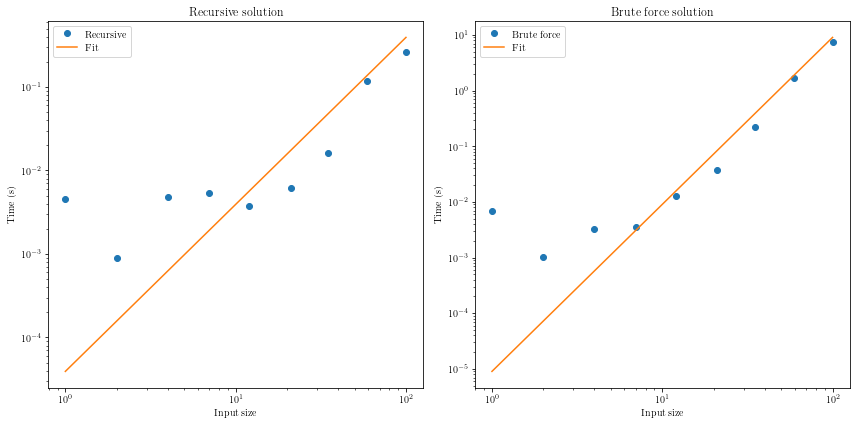

In [ ]:
# plot the average times for recursive and brute on separate plots along with their fits
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(input_sizes, np.mean(recursive_times, axis=1), 'o', label='Recursive')
plt.plot(input_sizes, 10**poly_fit_recursive(log_input_sizes, *popt_recursive), label='Fit')
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Input size')
plt.ylabel('Time (s)')
plt.title('Recursive solution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(input_sizes, np.mean(brute_force_times, axis=1), 'o', label='Brute force')
plt.plot(input_sizes, 10**poly_fit_brute(log_input_sizes, *popt_brute_force), label='Fit')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Input size')
plt.ylabel('Time (s)')
plt.title('Brute force solution')
plt.legend()

plt.tight_layout()
plt.show()